# Preliminary analysis: Gender Imbalance

Here we just explored the case numbers in Germany, France, England and Scotland.


In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Matplotlib configs
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def process(df, agegroups, smoothing=7):
    new = pd.DataFrame(index=df[(df.gender=="total")&(df.age_group=="total")].date, columns=["male_cases","female_cases"])
    tmp = df[df.age_group.isin(agegroups)]
    new.loc[:,"male_cases"]=tmp[tmp.gender=="male"].groupby("date").sum().cases.values
    new.loc[:,"female_cases"]=tmp[tmp.gender=="female"].groupby("date").sum().cases.values
    new = new.rolling(smoothing,center=True).mean()
    new = new[datetime(2021,5,1):datetime(2021,7,31)]
    return new

In [4]:
def divide_by_population(data):
    pop = pd.read_csv("../data/countries.csv")
    pop = pop.set_index("country")
    
    data[0]["male_cases"] = data[0]["male_cases"]/(pop.loc["Germany"]["population_male"]/1e6)
    data[0]["female_cases"] = data[0]["female_cases"]/(pop.loc["Germany"]["population_female"]/1e6)
    
    data[1]["male_cases"] = data[1]["male_cases"]/(pop.loc["France"]["population_male"]/1e6)
    data[1]["female_cases"] = data[1]["female_cases"]/(pop.loc["France"]["population_female"]/1e6)

    
    data[2]["male_cases"] = data[2]["male_cases"]/(pop.loc["England"]["population_male"]/1e6)
    data[2]["female_cases"] = data[2]["female_cases"]/(pop.loc["England"]["population_female"]/1e6)
    data[3]["male_cases"] = data[3]["male_cases"]/(pop.loc["Scotland"]["population_male"]/1e6)
    data[3]["female_cases"] = data[3]["female_cases"]/(pop.loc["Scotland"]["population_female"]/1e6)
    
    return data

In [5]:
de = pd.read_csv("../data/case_data_gender/DE.csv", parse_dates=["date"])
fr = pd.read_csv("../data/case_data_gender/FR.csv", parse_dates=["date"])
gb = pd.read_csv("../data/case_data_gender/GB-ENG.csv", parse_dates=["date"])
sct = pd.read_csv("../data/case_data_gender/GB-SCT.csv", parse_dates=["date"])

In [6]:
data = [process(de, ["total"]), process(fr, ["total"]), process(gb, ["total"]), process(sct, ["total"])]
data = divide_by_population(data)

In [7]:
awaygames = [[datetime(2021,6,29)],
             [datetime(2021,6,15),datetime(2021,6,19),datetime(2021,6,23),datetime(2021,6,28)],
             [datetime(2021,7,3)],
             [datetime(2021,6,18)]]
homegames = [[datetime(2021,6,15),datetime(2021,6,19),datetime(2021,6,23)],
             [],
             [datetime(2021,6,13),datetime(2021,6,18),datetime(2021,6,22),datetime(2021,6,29),
              datetime(2021,7,7),datetime(2021,7,11)],
             [datetime(2021,6,14),datetime(2021,6,22)]]

In [8]:
# Taken from https://makeitso.one/
colors_paul = ["#233954", "#ea5e48", "#1e7d72", "#f49546", "#e8bf58", # dark
               "#5886be", "#f3a093", "#53d8c9", "#f2da9c", "#f9c192"] # light

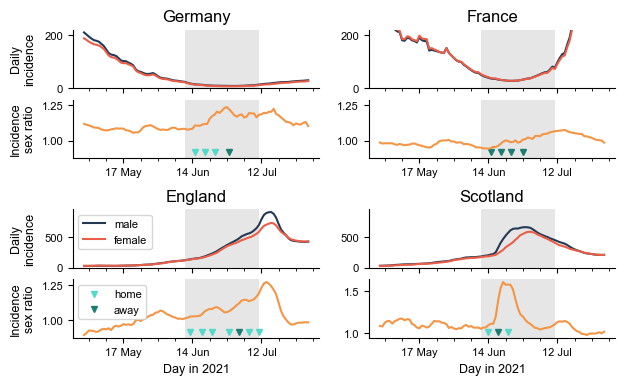

In [9]:
# reset defaults


color ={"male":   colors_paul[0],
        "female": colors_paul[1],
        "ratio":  colors_paul[3],
        "home":   colors_paul[7],
        "away":   colors_paul[2],}


fig = plt.figure(figsize=(7, 4))
outer_grid = fig.add_gridspec(ncols=2, nrows=2, hspace=0.4)

axss = [0,0,0,0]
for i in range(2):
    for j in range(2):
        inner_grid = outer_grid[i,j].subgridspec(2,1)
        axss[2*i+j] = inner_grid.subplots(sharex=True)

axss[0][0].get_shared_y_axes().join(axss[0][0], axss[1][0])
axss[2][0].get_shared_y_axes().join(axss[2][0], axss[3][0])
axss[0][1].get_shared_y_axes().join(axss[0][1], axss[1][1], axss[2][1])


titles = ["Germany", "France", "England", "Scotland"]

for i,axs in enumerate(axss):
    axs[0].set_title(titles[i])
    axs[0].plot_date(data[i].index, data[i]["male_cases"], '-', color=color["male"], label="male")
    axs[0].plot_date(data[i].index, data[i]["female_cases"], '-', color=color["female"], label="female")
    axs[0].set_ylim(0,None)
    axs[1].plot_date(data[i].index, data[i]["male_cases"]/data[i]["female_cases"], '-', color=color["ratio"])

    trans = mpl.transforms.blended_transform_factory(axs[1].transData, axs[1].transAxes)
    for date in awaygames[i]:
        axs[1].plot_date(date, 0.1, transform=trans, fmt='v', markersize=5,
                         markerfacecolor=color["away"], markeredgecolor=color["away"], zorder=1)
    for date in homegames[i]:
        axs[1].plot_date(date, 0.1, transform=trans, fmt='v', markersize=5,
                         markerfacecolor=color["home"], markeredgecolor=color["home"], zorder=1)
        
    for ax in axs:
        ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.MO, interval=1))
        ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.MO, interval=4))
        ax.xaxis.set_major_formatter( mpl.dates.DateFormatter('%d %b') )
        ax.axvspan(datetime(2021,6,11), datetime(2021,7,11), facecolor=[.9,.9,.9])

        
axss[2][0].set_ylabel("Daily\nincidence")
axss[2][1].set_ylabel("Incidence\nsex ratio")
axss[0][0].set_ylabel("Daily\nincidence")
axss[0][1].set_ylabel("Incidence\nsex ratio")
axss[2][1].set_xlabel("Day in 2021")
axss[3][1].set_xlabel("Day in 2021")


axss[2][0].legend()
homemarker = mpl.lines.Line2D([], [], color=color["home"], marker='v', linestyle='None',
                              markersize=5, label='home')
awaymarker = mpl.lines.Line2D([], [], color=color["away"], marker='v', linestyle='None',
                              markersize=5, label='away')
axss[2][1].legend(handles=[homemarker, awaymarker], loc="upper left")

fig.align_ylabels()

plt.show()
fig.savefig("../figures/preliminary_cases-and-gender-imbalance.png",**save_kwargs)
fig.savefig("../figures/preliminary_cases-and-gender-imbalance.pdf",**save_kwargs)